# **Bayesian Networks**

- ## *Bayesian Networks Design, Model Training, Model Inference and Evaluation*


This notebook documents the design, training, and evaluation of the Bayesian Network (BN) developed for diagnosing spindle overheating events in a CNC milling machine.

The objective of this Bayesian Network is to:

- Model uncertainty in sensor measurements

- Infer latent root causes of failures

- Estimate the probability of spindle overheating

- Support explainable decision-making for maintenance actions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pgmpy.models import BayesianNetwork, DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

/Users/sarataboas/.pyenv/versions/tsi-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data Preparation for the Bayesian Network**

#### **Merging Data**

In [2]:
from src.bn_data_prepaparation import *

Before constructing the Bayesian Network, we first merge all relevant datasets to obtain a unified view of the system state at each timestamp. This includes:

- Telemetry sensor data (*telemetry.csv*)

- Overheating labels (*labels.csv*)

- Maintenance actions (*maintenance.csv*)

In [3]:
telemetry_data = pd.read_csv('data/telemetry.csv')
labels_data = pd.read_csv('data/labels.csv')

In [4]:
data = telemetry_data.merge(labels_data, on = ('machine_id','timestamp'))
data.drop(columns=['timestamp'], inplace=True)
data.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-A,73.96,24.36,0.871,1.050,0.9,3600,0.294,3.193,0.000,0
1,M-A,53.38,22.87,0.536,1.083,1.3,800,0.329,2.149,0.000,0
2,M-A,58.12,24.59,0.455,1.025,0.9,1200,0.369,2.457,0.001,0
3,M-A,58.08,23.05,0.680,0.977,0.7,1200,0.479,2.702,0.001,0
4,M-A,55.37,24.28,0.663,1.072,1.1,800,0.328,2.148,0.001,0


#### **Discretization of Countinuous Variables**

Bayesian Networks in *pgmpy* operate on discrete variables. Therefore, continuous sensor measurements were transformed into categorical states.

We discretize each numerical feature into three levels, ...:

- Low

- Normal

- High

... using quantile-based thresholds (25rd and 75th percentiles), resulting in three balanced categories (low, normal, high).

- (< Q1): Low

- Between Q1 and Q2: Normal

- (> Q2): High

- **Visual representation of the values by category {Low, Normal, High}**

In [5]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("Countinuous columns: ", num_cols)

Countinuous columns:  ['spindle_temp', 'ambient_temp', 'vibration_rms', 'coolant_flow', 'feed_rate', 'spindle_speed', 'load_pct', 'power_kw', 'tool_wear', 'spindle_overheat']


In [6]:
discretization_thresholds(data, num_cols)

Ignore columns 'spindle_overheat' (only has 1 unique values).


,feature,low (<= q1),high (> q2)
0,spindle_temp,63.3175,72.580
1,ambient_temp,17.9800,26.020
2,vibration_rms,0.8630,1.111
3,coolant_flow,0.4280,0.581
4,feed_rate,0.9000,1.300
5,spindle_speed,1200.0000,2800.000
6,load_pct,0.3550,0.666
7,power_kw,2.6430,3.896
8,tool_wear,1.0000,1.000


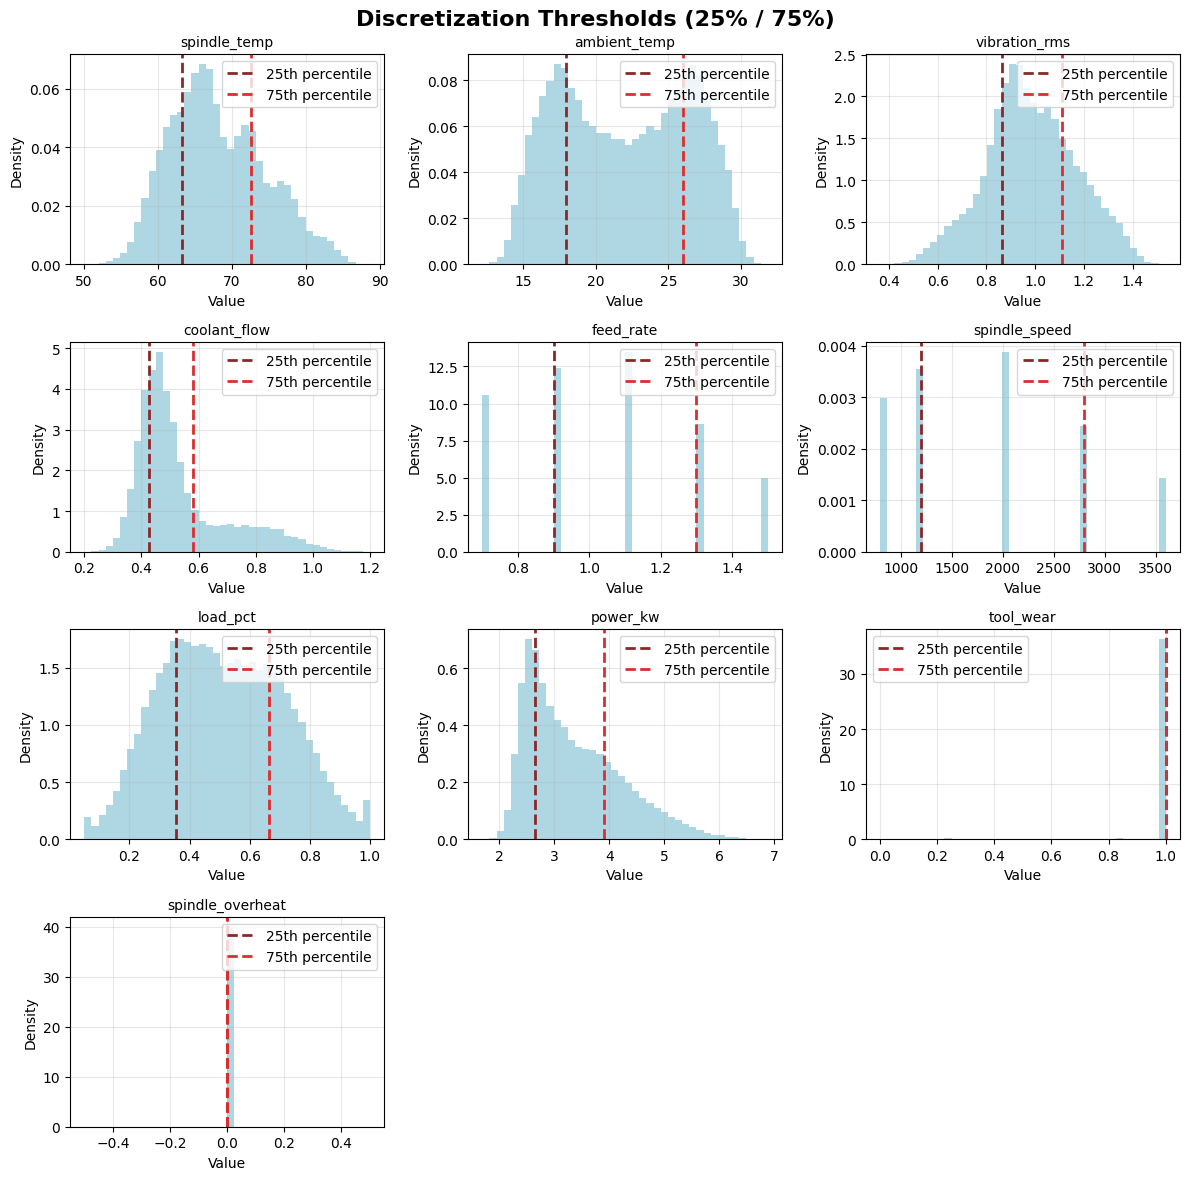

In [7]:
plot_discretization_thresholds(data, percentiles=(0.25, 0.75))

In [8]:
thresholds = fit_discretizer(data, q_low=0.25, q_high=0.75)
data_discrete = apply_discretizer(data, thresholds, labels=("low","normal","high"))

In [9]:
print("Data Types After Discretization:")
print(data_discrete.dtypes)
data_discrete.head()

Data Types After Discretization:
machine_id            object
spindle_temp        category
ambient_temp        category
vibration_rms       category
coolant_flow        category
feed_rate           category
spindle_speed       category
load_pct            category
power_kw            category
tool_wear           category
spindle_overheat       int64
dtype: object


,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-A,high,normal,normal,high,low,high,low,normal,low,0
1,M-A,low,normal,low,high,normal,low,low,low,low,0
2,M-A,low,normal,low,high,low,low,normal,low,low,0
3,M-A,low,normal,low,high,low,low,normal,normal,low,0
4,M-A,low,normal,low,high,normal,low,low,low,low,0


In [10]:
save_discretizer(thresholds, "data/build_data/discretizer.pkl")

Discretizer saved to: data/build_data/discretizer.pkl


#### **Defining Spindle Overheat**

To define the Spindle Overheat condition, we used the rule suggested in class, which relies on the readings from one or two sensors. Specifically, a case is considered a probable overheat if:

- the spindle temperature is considered ***'high'***, with values above 72,580°C, or

- the vibration RMS is considered ***'high'*** (values above ~1.11) and the coolant flow is considered ***'low'*** (values below 0.428).

From these probable cases, we classify approximately 50% as Overheat = "Yes", while the remaining cases (including all non-probable ones) are classified as Overheat = "No".

In [11]:
cond = (
    (data_discrete["spindle_temp"] == 'high') |
    ((data["vibration_rms"] == 'high') & (data_discrete["coolant_flow"] == 'low'))
)

In [12]:
data_with_new_rule = spindle_overheat_from_condition(data_discrete, cond)
data_with_new_rule.head()

/Users/sarataboas/Desktop/master/intelligent_systems/Intelligent-System-for-Industrial-Equipment-Failure-Diagnosis/src/bn_data_prepaparation.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Yes' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "spindle_overheat"] = 'Yes'


,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-A,high,normal,normal,high,low,high,low,normal,low,Yes
1,M-A,low,normal,low,high,normal,low,low,low,low,No
2,M-A,low,normal,low,high,low,low,normal,low,low,No
3,M-A,low,normal,low,high,low,low,normal,normal,low,No
4,M-A,low,normal,low,high,normal,low,low,low,low,No


In [13]:
print("Spindle_overheat Distribution:")
print(data_with_new_rule["spindle_overheat"].value_counts())
data_with_new_rule.head()

Spindle_overheat Distribution:
spindle_overheat
No     90711
Yes    12969
Name: count, dtype: int64


,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-A,high,normal,normal,high,low,high,low,normal,low,Yes
1,M-A,low,normal,low,high,normal,low,low,low,low,No
2,M-A,low,normal,low,high,low,low,normal,low,low,No
3,M-A,low,normal,low,high,low,low,normal,normal,low,No
4,M-A,low,normal,low,high,normal,low,low,low,low,No


#### **Train and Test Split**

In [14]:
from sklearn.model_selection import train_test_split
data, test_df = train_test_split(data_with_new_rule, test_size=0.2, random_state=42, shuffle=True)


In [15]:
print("Training set shape:", data.shape)
print("Training set distribution:")
print(data["spindle_overheat"].value_counts())
data.to_csv('data/build_data/data_train.csv', index=False)

Training set shape: (82944, 11)
Training set distribution:
spindle_overheat
No     72600
Yes    10344
Name: count, dtype: int64


In [16]:
data.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
77677,M-C,normal,low,normal,normal,normal,normal,normal,high,low,No
71807,M-C,normal,normal,normal,low,normal,low,high,normal,low,No
45277,M-B,normal,high,normal,high,low,low,normal,low,low,No
29973,M-B,low,high,low,high,high,low,low,low,low,No
19896,M-A,normal,normal,low,normal,low,low,normal,normal,low,No


In [17]:
print("Test set shape:", test_df.shape)
print("Test set distribution:")
print(test_df["spindle_overheat"].value_counts())
test_df.to_csv('data/build_data/data_test.csv', index=False)

Test set shape: (20736, 11)
Test set distribution:
spindle_overheat
No     18111
Yes     2625
Name: count, dtype: int64


In [18]:
test_df.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
94897,M-D,high,normal,high,normal,normal,normal,high,high,low,Yes
11985,M-A,low,normal,normal,high,normal,low,high,normal,low,No
47781,M-B,low,low,low,low,low,low,low,low,low,No
85348,M-D,high,high,high,normal,low,normal,low,normal,low,Yes
25330,M-A,normal,normal,normal,low,low,low,low,low,low,No


## **Bayesian Network Construction**

In [19]:
from src.bn_desing_and_training import *

### Model A : Supervised Spindle Overheat

In [20]:
data_train = pd.read_csv('data/build_data/data_train.csv')
data_train.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-C,normal,low,normal,normal,normal,normal,normal,high,low,No
1,M-C,normal,normal,normal,low,normal,low,high,normal,low,No
2,M-B,normal,high,normal,high,low,low,normal,low,low,No
3,M-B,low,high,low,high,high,low,low,low,low,No
4,M-A,normal,normal,low,normal,low,low,normal,normal,low,No


In [21]:
data_train.isna().sum()

machine_id          0
spindle_temp        0
ambient_temp        0
vibration_rms       0
coolant_flow        0
feed_rate           0
spindle_speed       0
load_pct            0
power_kw            0
tool_wear           0
spindle_overheat    0
dtype: int64

#### ***MLE Parameter Estimation***

In [22]:
edges_mle = get_edges(with_latent_causes=False, with_maintenance=False, printing=True)

Edges =[
        ('spindle_temp', 'spindle_overheat')
        ('coolant_flow', 'spindle_overheat')
        ('vibration_rms', 'spindle_overheat')
]


In [23]:
cols_model_mle = get_cols_model(supervised=True, with_maintenance=False, printing=True)

Columns to the model = [
        spindle_temp
        coolant_flow
        vibration_rms
        spindle_speed
        spindle_overheat
]


In [24]:
model_mle = build_bayesian_network(edges_mle)
print("Bayesian Network structure (MLE):", model_mle)

Bayesian Network structure (MLE): DiscreteBayesianNetwork with 4 nodes and 3 edges


In [25]:
train_bn(model=model_mle, data=data_train, cols_model=cols_model_mle, estimator_name="mle")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'spindle_temp': 'C', 'coolant_flow': 'C', 'vibration_rms': 'C', 'spindle_speed': 'C', 'spindle_overheat': 'C'}


In [26]:
print_cpds(model_mle)


Variable: spindle_temp
+----------------------+----------+
| spindle_temp(high)   | 0.248457 |
+----------------------+----------+
| spindle_temp(low)    | 0.251362 |
+----------------------+----------+
| spindle_temp(normal) | 0.500181 |
+----------------------+----------+

Variable: spindle_overheat
+-----------------------+---------------------+---------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+
| coolant_flow          | coolant_flow(high)  | coo

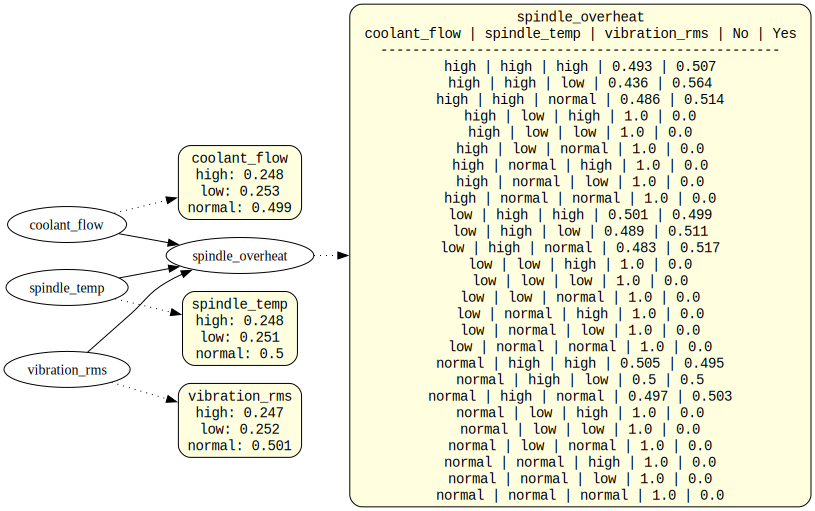

In [27]:
dot_mle = plot_bn_with_table_cpds(model_mle)
dot_mle

In [28]:
save_model(model_mle, 'models/bn_model_mle.bif')

#### ***EM Parameter Learning***

In [29]:
edges_em = get_edges(with_latent_causes=True, with_maintenance=False, printing=True)

Edges =[
        ('spindle_temp', 'spindle_overheat')
        ('coolant_flow', 'spindle_overheat')
        ('vibration_rms', 'spindle_overheat')
        ('BearingWearHigh', 'vibration_rms')
        ('FanFault', 'spindle_temp')
        ('CloggedFilter', 'coolant_flow')
        ('LowCoolingEfficiency', 'spindle_temp')
]


In [30]:
latent_causes = get_latent_causes(supervised=True, printing=True)

Latent_causes = {
        FanFault
        BearingWearHigh
        LowCoolingEfficiency
        CloggedFilter
}


In [31]:
cols_model_em = get_cols_model(supervised=True, with_maintenance=False, printing=True)

Columns to the model = [
        spindle_temp
        coolant_flow
        vibration_rms
        spindle_speed
        spindle_overheat
]


- **Training the Bayesian Network with EM from random initial parameters**

In [32]:
model_em_A = build_bayesian_network(edges_em, latent_causes=latent_causes)
print("Bayesian Network structure (EM):", model_em_A)

Bayesian Network structure (EM): DiscreteBayesianNetwork with 8 nodes and 7 edges


In [33]:
train_bn(model_em_A, data_train, cols_model_em, estimator_name='em', init_model=None)
print("Bayesian Network structure (EM):", model_em_A)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'spindle_temp': 'C', 'coolant_flow': 'C', 'vibration_rms': 'C', 'spindle_speed': 'C', 'spindle_overheat': 'C'}
  2%|▏         | 2/100 [00:00<00:10,  9.21it/s]

Bayesian Network structure (EM): DiscreteBayesianNetwork with 8 nodes and 7 edges


In [34]:
print_cpds(model_em_A)


Variable: spindle_overheat
+-----------------------+---------------------+---------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+
| coolant_flow          | coolant_flow(high)  | coolant_flow(high)  | coolant_flow(high)    | coolant_flow(high)  | coolant_flow(high) | coolant_flow(high)    | coolant_flow(high)   | coolant_flow(high)   | coolant_flow(high)    | coolant_flow(low)   | coolant_flow(low)  | coolant_flow(low)     | coolant_flow(low)   | coolant

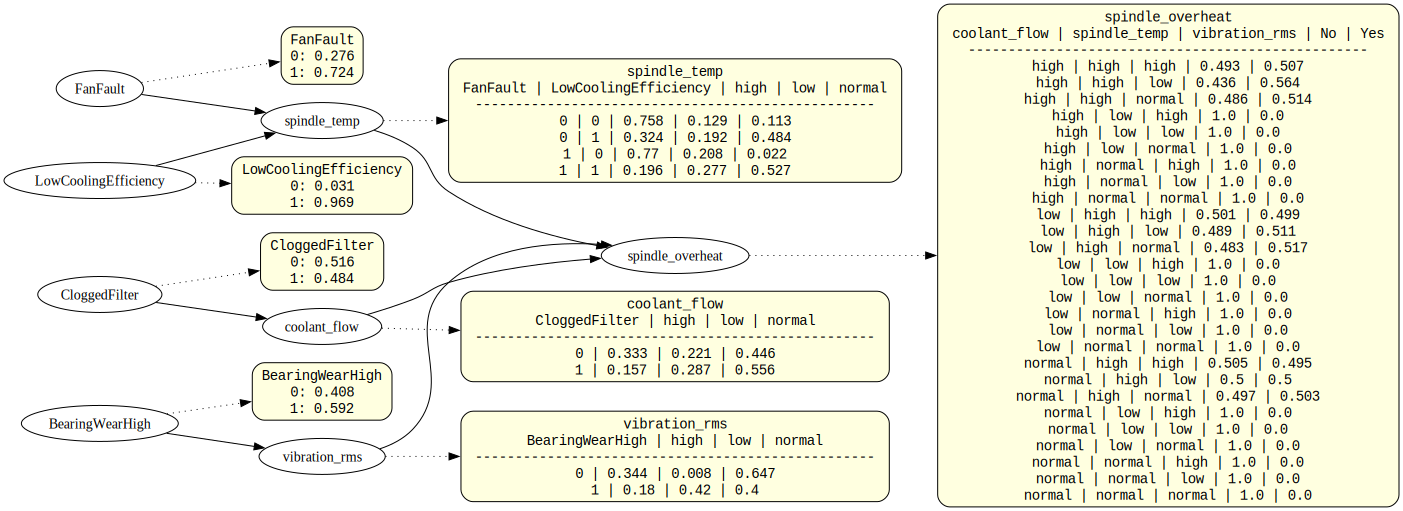

In [35]:
plot_bn_with_table_cpds(model_em_A)

In [36]:
save_model(model_em_A, 'models/bn_model_em_A.bif')

- **Training the Bayesian Network with EM from MLE trained parameters**

In [37]:
model_em_from_mle = build_bayesian_network(edges_em, latent_causes=latent_causes)
print("Bayesian Network structure (EM from MLE):", model_em_from_mle)

Bayesian Network structure (EM from MLE): DiscreteBayesianNetwork with 8 nodes and 7 edges


In [38]:
train_bn(model_em_from_mle, data_train, cols_model_em, estimator_name="em", init_model=model_mle)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'spindle_temp': 'C', 'coolant_flow': 'C', 'vibration_rms': 'C', 'spindle_speed': 'C', 'spindle_overheat': 'C'}
  5%|▌         | 5/100 [00:00<00:08, 11.84it/s]


In [39]:
print_cpds(model_em_from_mle)


Variable: spindle_overheat
+-----------------------+---------------------+---------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------+---------------------+--------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+----------------------+-----------------------+
| coolant_flow          | coolant_flow(high)  | coolant_flow(high)  | coolant_flow(high)    | coolant_flow(high)  | coolant_flow(high) | coolant_flow(high)    | coolant_flow(high)   | coolant_flow(high)   | coolant_flow(high)    | coolant_flow(low)   | coolant_flow(low)  | coolant_flow(low)     | coolant_flow(low)   | coolant

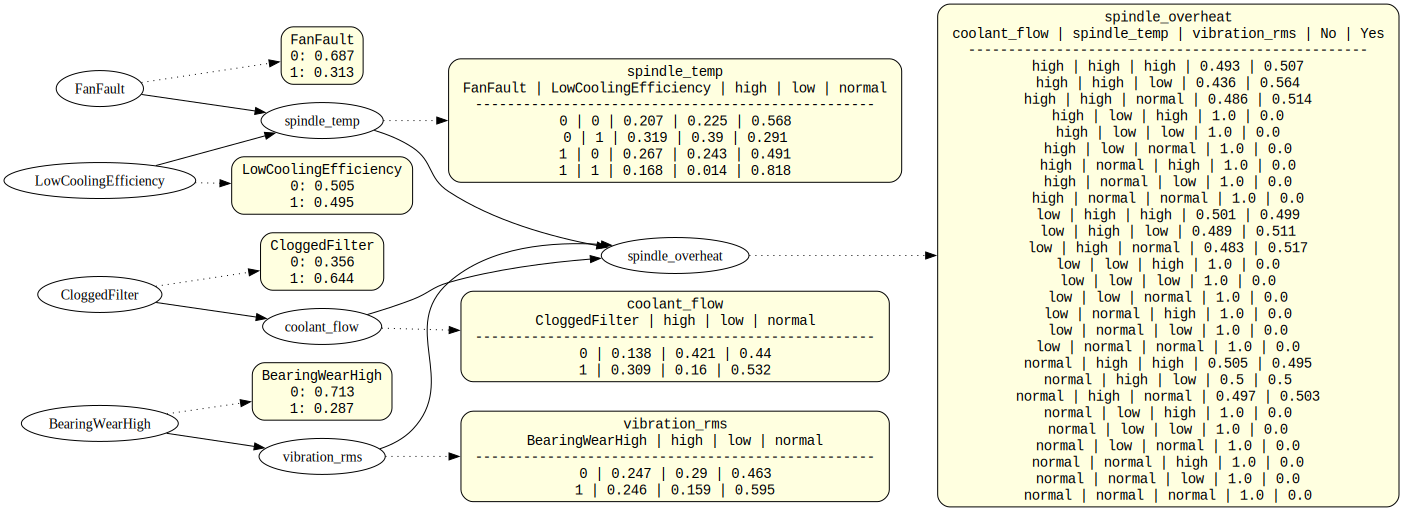

In [40]:
plot_bn_with_table_cpds(model_em_from_mle)

In [41]:
save_model(model_em_from_mle, 'models/bn_model_em_from_mle.bif')

### Model B : Latent Spindle Overheat

In [42]:
edges_em = get_edges(with_latent_causes=True, with_maintenance=False, printing=True)

Edges =[
        ('spindle_temp', 'spindle_overheat')
        ('coolant_flow', 'spindle_overheat')
        ('vibration_rms', 'spindle_overheat')
        ('BearingWearHigh', 'vibration_rms')
        ('FanFault', 'spindle_temp')
        ('CloggedFilter', 'coolant_flow')
        ('LowCoolingEfficiency', 'spindle_temp')
]


In [43]:
latent_causes_em = get_latent_causes(supervised=False, printing=True)

Latent_causes = {
        FanFault
        BearingWearHigh
        CloggedFilter
        spindle_overheat
        LowCoolingEfficiency
}


In [44]:
cols_model_em = get_cols_model(supervised=False, with_maintenance=False, printing=True)

Columns to the model = [
        spindle_temp
        coolant_flow
        vibration_rms
        spindle_speed
]


In [45]:
model_em_B = build_bayesian_network(edges_em, latent_causes=latent_causes_em)
print("Bayesian Network structure (EM):", model_em_B)

Bayesian Network structure (EM): DiscreteBayesianNetwork with 8 nodes and 7 edges


In [46]:
train_bn(model_em_B, data_train, cols_model_em, estimator_name="em", init_model=None)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'spindle_temp': 'C', 'coolant_flow': 'C', 'vibration_rms': 'C', 'spindle_speed': 'C'}
  3%|▎         | 3/100 [00:00<00:13,  7.22it/s]


In [47]:
print_cpds(model_em_B)


Variable: FanFault
+-------------+----------+
| FanFault(0) | 0.142298 |
+-------------+----------+
| FanFault(1) | 0.857702 |
+-------------+----------+

Variable: BearingWearHigh
+--------------------+----------+
| BearingWearHigh(0) | 0.151871 |
+--------------------+----------+
| BearingWearHigh(1) | 0.848129 |
+--------------------+----------+

Variable: coolant_flow
+----------------------+---------------------+---------------------+
| CloggedFilter        | CloggedFilter(0)    | CloggedFilter(1)    |
+----------------------+---------------------+---------------------+
| coolant_flow(high)   | 0.17282614632666887 | 0.26139331081065487 |
+----------------------+---------------------+---------------------+
| coolant_flow(low)    | 0.4171829669889836  | 0.2233423791779605  |
+----------------------+---------------------+---------------------+
| coolant_flow(normal) | 0.4099908866843476  | 0.5152643100113848  |
+----------------------+---------------------+---------------------+

Va

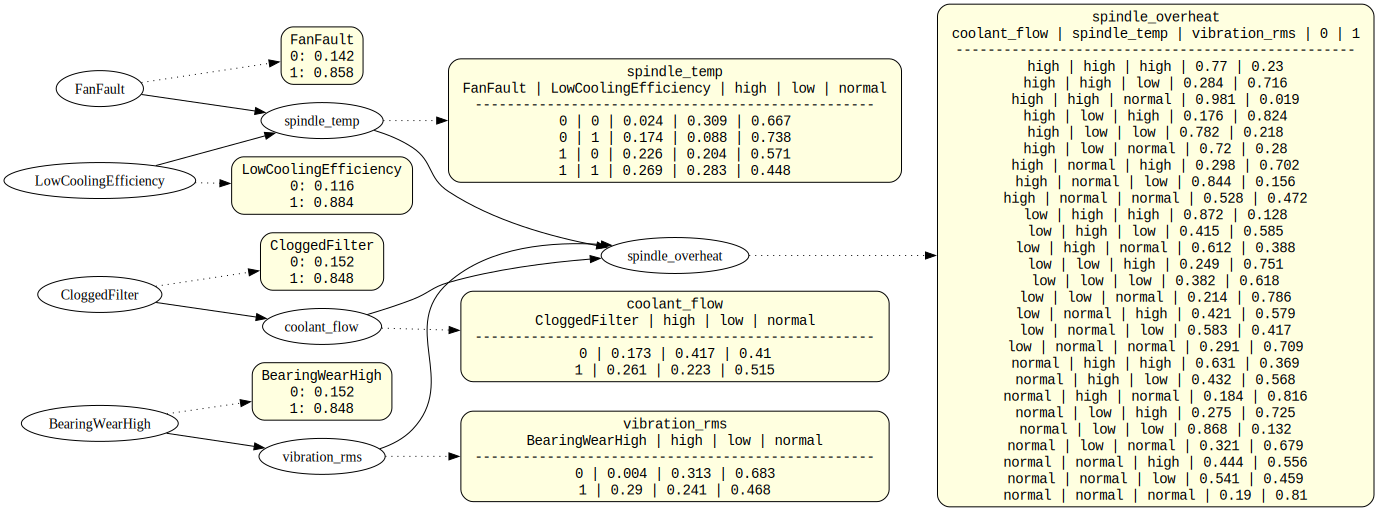

In [48]:
plot_bn_with_table_cpds(model_em_B)

In [49]:
save_model(model_em_B, 'models/bn_model_em_B.bif')

----

## **Model Inference**

In [50]:
from src.bn_inference import *

In [51]:
test_df = pd.read_csv('data/build_data/data_test.csv')
test_df.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-D,high,normal,high,normal,normal,normal,high,high,low,Yes
1,M-A,low,normal,normal,high,normal,low,high,normal,low,No
2,M-B,low,low,low,low,low,low,low,low,low,No
3,M-D,high,high,high,normal,low,normal,low,normal,low,Yes
4,M-A,normal,normal,normal,low,low,low,low,low,low,No


In [52]:
model_mle = load_model('models/bn_model_mle.bif')
model_em_A = load_model('models/bn_model_em_A.bif')
model_em_from_mle = load_model('models/bn_model_em_from_mle.bif')
model_em_B = load_model('models/bn_model_em_B.bif')

#### **Inference on a specific instance**

In [53]:
instance_index = 29

In [54]:
row = test_df.iloc[instance_index]
evidence = {
    "spindle_temp": row["spindle_temp"],
    "coolant_flow": row["coolant_flow"],
    "vibration_rms": row["vibration_rms"]
}
print("Test instance evidence:")
for k, v in evidence.items():
    print(f"  • {k}: {v}") 

Test instance evidence:
  • spindle_temp: high
  • coolant_flow: normal
  • vibration_rms: high


In [55]:
possible_causes = get_latent_causes(supervised=True, printing=True)

Latent_causes = {
        FanFault
        BearingWearHigh
        LowCoolingEfficiency
        CloggedFilter
}


In [56]:
p_overheat = infer_case(model=model_em_from_mle, row=row, features=["spindle_temp", "coolant_flow", "vibration_rms"], target="spindle_overheat", causes=possible_causes, threshold=0.5)


================ CASE ANALYSIS ================

Evidence:


,Value
spindle_temp,high
coolant_flow,normal
vibration_rms,high



Target probability:


,spindle_overheat,Probability
0,No,0.504857
1,Yes,0.495143



Risk level: MEDIUM

Probable causes:


,Probability
CloggedFilter,0.686297
LowCoolingEfficiency,0.541612
BearingWearHigh,0.286193


------

## **Model Evaluation**

In [57]:
from src.bn_evaluation import *

In [58]:
test_df = pd.read_csv('data/build_data/data_test.csv')
test_df.head()

,machine_id,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear,spindle_overheat
0,M-D,high,normal,high,normal,normal,normal,high,high,low,Yes
1,M-A,low,normal,normal,high,normal,low,high,normal,low,No
2,M-B,low,low,low,low,low,low,low,low,low,No
3,M-D,high,high,high,normal,low,normal,low,normal,low,Yes
4,M-A,normal,normal,normal,low,low,low,low,low,low,No


In [59]:
print(cols_model_mle)
cols_model = ['spindle_temp', 'coolant_flow', 'vibration_rms', 'spindle_overheat']

['spindle_temp', 'coolant_flow', 'vibration_rms', 'spindle_speed', 'spindle_overheat']


In [60]:
results = evaluate_model(
    model_mle,
    test_df,
    features=["coolant_flow","spindle_temp","vibration_rms"],
    target="spindle_overheat"
)



Accuracy: 0.8741319444444444

Confusion Matrix:
 [[16913  1198]
 [ 1412  1213]]

Classification Report:
               precision    recall  f1-score   support

          No       0.92      0.93      0.93     18111
         Yes       0.50      0.46      0.48      2625

    accuracy                           0.87     20736
   macro avg       0.71      0.70      0.71     20736
weighted avg       0.87      0.87      0.87     20736



In [61]:
results = evaluate_model(
    model_em_A,
    test_df,
    features=["coolant_flow","spindle_temp","vibration_rms"],
    target="spindle_overheat"
)



Accuracy: 0.8741319444444444

Confusion Matrix:
 [[16913  1198]
 [ 1412  1213]]

Classification Report:
               precision    recall  f1-score   support

          No       0.92      0.93      0.93     18111
         Yes       0.50      0.46      0.48      2625

    accuracy                           0.87     20736
   macro avg       0.71      0.70      0.71     20736
weighted avg       0.87      0.87      0.87     20736



In [62]:
results = evaluate_model(
    model_em_from_mle,
    test_df,
    features=["coolant_flow","spindle_temp","vibration_rms"],
    target="spindle_overheat"
)



Accuracy: 0.8741319444444444

Confusion Matrix:
 [[16913  1198]
 [ 1412  1213]]

Classification Report:
               precision    recall  f1-score   support

          No       0.92      0.93      0.93     18111
         Yes       0.50      0.46      0.48      2625

    accuracy                           0.87     20736
   macro avg       0.71      0.70      0.71     20736
weighted avg       0.87      0.87      0.87     20736



In [63]:
results = evaluate_model(
    model_em_B,
    test_df,
    features=["coolant_flow","spindle_temp","vibration_rms"],
    target="spindle_overheat"
)



Accuracy: 0.4458429783950617

Confusion Matrix:
 [[8824 9287]
 [2204  421]]

Classification Report:
               precision    recall  f1-score   support

          No       0.80      0.49      0.61     18111
         Yes       0.04      0.16      0.07      2625

    accuracy                           0.45     20736
   macro avg       0.42      0.32      0.34     20736
weighted avg       0.70      0.45      0.54     20736

